# App-ifying 'recovering data from images'

**See [the other notebook](Guessing_colourmaps.ipynb) for the grisly details and dead-ends.** 

Requirements:

- `numpy`
- `scipy`
- `scikit-learn`
- `pillow`

I recommend installing them with `conda install`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Make an image

Make some fake data and apply a colourmap.

In [2]:
from scipy import signal

In [3]:
nx, ny = 100, 100
z = np.random.rand(nx, ny)

sizex, sizey = 30, 30
x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
f = g/g.sum()

z = signal.convolve(z, f, mode='valid')
z = (z - z.min())/(z.max() - z.min())

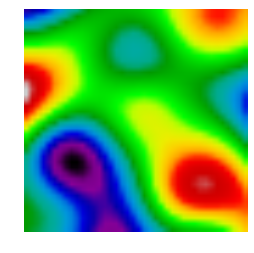

In [4]:
# Note: interpolation introduces new colours.
plt.imshow(z, cmap="spectral")
#plt.imshow(z, cmap="spectral", interpolation='none')

plt.axis('off')
plt.savefig('data/cbar/test.png', bbox_inches='tight')
plt.show()

## Read an image

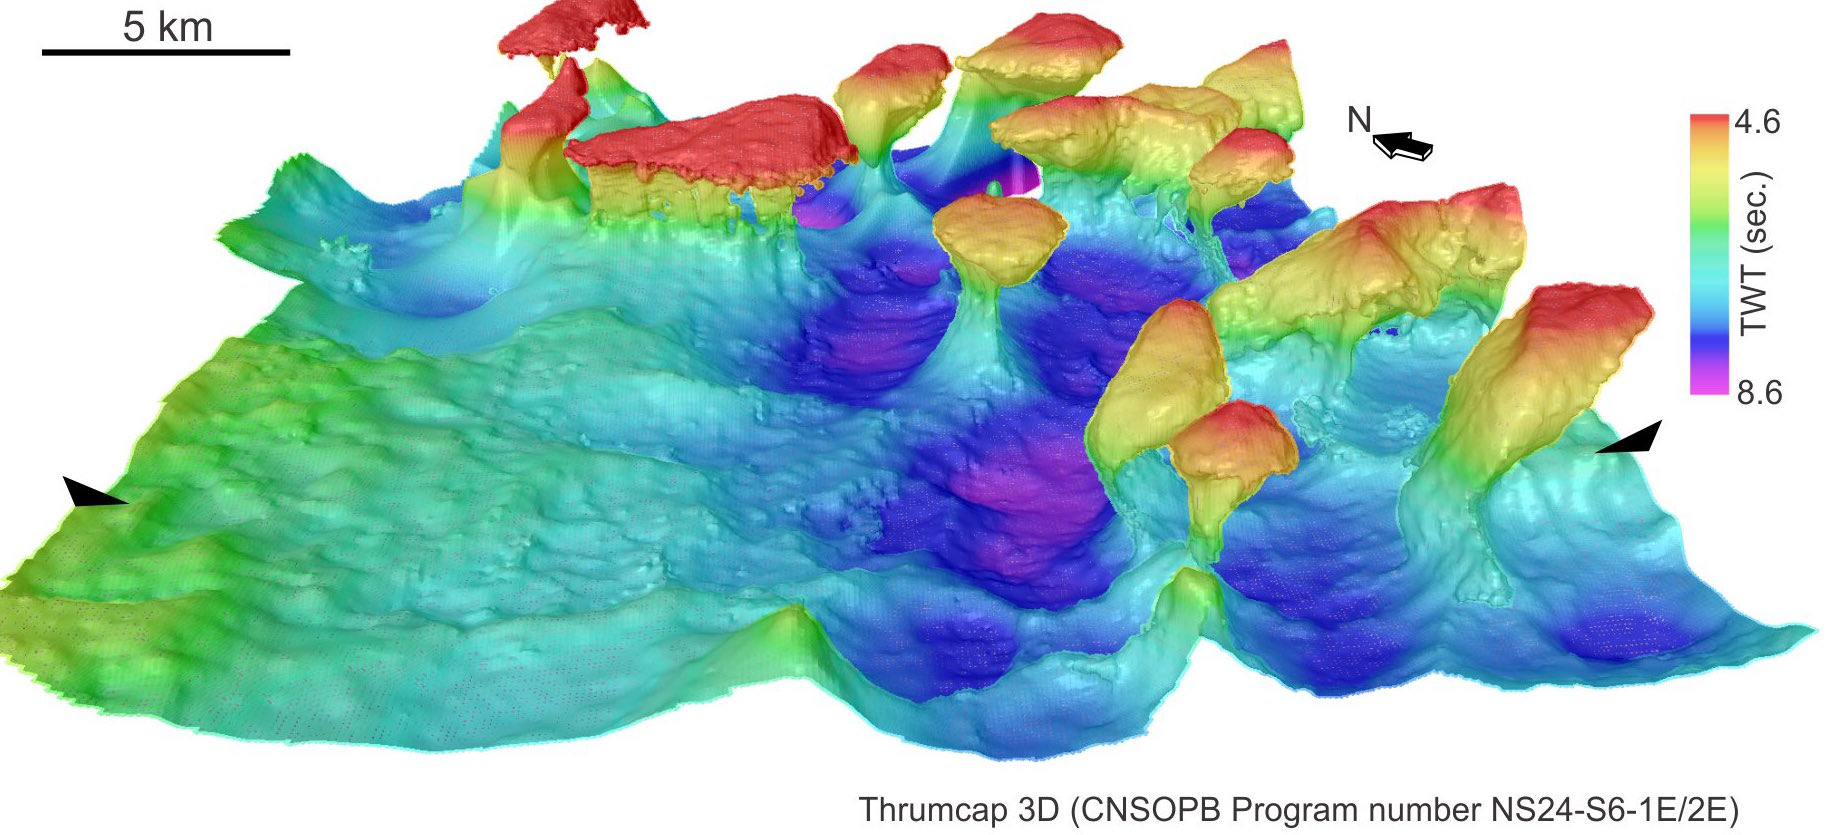

In [7]:
from PIL import Image

#im = Image.open('data/cbar/drainage.jpg')
#img = Image.open('data/cbar/test.png')
img = Image.open('data/cbar/deptuck_salt.jpg')

img

In [8]:
img.size

(1830, 835)

Instead of taking a random sample, let's take all pixels from a smaller version of the image.

In [7]:
def resize_if_necessary(img, max_size=256):
    h, w = img.size
    if h * w > max_size**2:
        img = img.resize((max_size, max_size))
    return img

In [8]:
img_sm = resize_if_necessary(img, 100)

Cast as an array, and ignore the last channel (alpha), if there is one.

Now we can plot all the pixels in the image into (R, G, B) space. As an added bonus, we can also colour the points with that (R, G, B) colour. 

In [9]:
i = np.asarray(img_sm)[:,:,:3]
# Re-organize the pixels to use rgb triples for colour
h, w, d = i.shape
c = i.reshape((h*w, d)) / 255

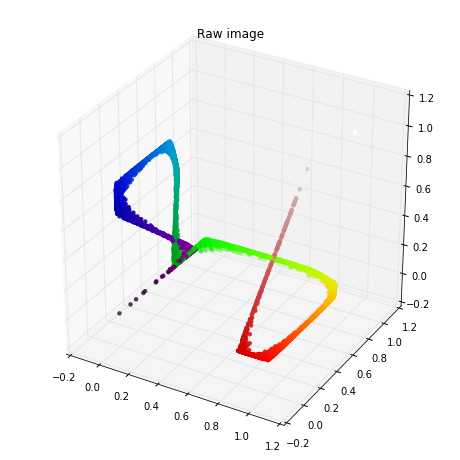

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the pixels!
ax.scatter(*c.T, c=c, lw=0)
ax.set_title('Raw image')

plt.show()

## Quantize with scikit

In [11]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [12]:
im = np.asarray(img) / 255
h, w, d = im.shape
im_ = im.reshape((w * h, d))[:, :3]
sample = shuffle(im_, random_state=0)[:1000]  # Defines training set size

In [13]:
im.dtype, im.shape, im_.shape

(dtype('float64'), (253, 254, 4), (64262, 3))

In [14]:
kmeans = KMeans(n_clusters=256, random_state=0).fit(sample)

Now I can make and regularize an RGB palette `p`:

In [125]:
p = kmeans.cluster_centers_[:, :3]

# Make certain we're in [0, 1]
p[p<1e-9] = 0
p[p>1] = 1

In [16]:
labels = kmeans.predict(im_)

In [17]:
def recreate_image(palette, labels, h, w):
    image = np.zeros((h, w, palette.shape[1]))
    label_idx = 0
    for i in range(h):
        for j in range(w):
            image[i][j] = palette[labels[label_idx]]
            label_idx += 1
    return image

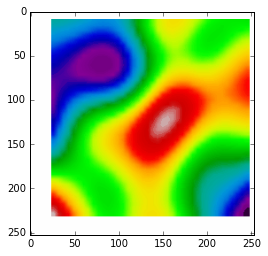

In [18]:
q = recreate_image(p, labels, h, w)

plt.imshow(q)
plt.show()

## Reconstructing the colourmap locus

Remember that these points are essentially in random order, and that there are many, many duplicates. Most of those dots are actually hundreds of dots.

We would like to measure ditances between dots. This is just a norm, but there's a convenient function in `scipy.spatial` for finding distances in *n*-space.

In [19]:
from scipy.spatial.distance import pdist, squareform, cdist
dists = squareform(pdist(p))

In [20]:
dists.shape, dists.size

((256, 256), 65536)

In [21]:
dists

array([[ 0.        ,  1.01365347,  1.36021473, ...,  1.01238771,
         0.71940806,  1.14744682],
       [ 1.01365347,  0.        ,  1.04060728, ...,  0.05176207,
         1.33966228,  0.71155293],
       [ 1.36021473,  1.04060728,  0.        , ...,  1.02766217,
         1.13093428,  1.41361127],
       ..., 
       [ 1.01238771,  0.05176207,  1.02766217, ...,  0.        ,
         1.34374889,  0.76231709],
       [ 0.71940806,  1.33966228,  1.13093428, ...,  1.34374889,
         0.        ,  1.37706462],
       [ 1.14744682,  0.71155293,  1.41361127, ...,  0.76231709,
         1.37706462,  0.        ]])

Each row is the set of distances for a point. Below is an excerpt of only the first 100 points.

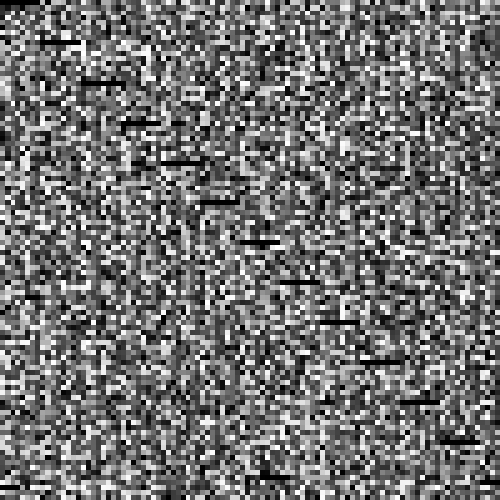

In [22]:
# The image is 10k x 10k pixels, so let's just look at a bit of it...
dist_img = Image.fromarray(dists[:100, :100]*255, 'P').resize((500, 500))
dist_img

I need an algorithm. I think this might work:

#### Preprocessing

* Find the median minimum non-zero distance between points, _m_ (nonzero because many points are exactly the same — colourbars are often only 6 or 8 bit).
* We are interested in points that are close to each other, but outside some minimum distance. Below the minimum distance, it's basically the same point. So ignore everything closer than some small distance _n_. Let's set _n_ to 0.2 &times; _m_ (we may need to change this).
* We want to eliminate points that are further than some maximum separation distance from the other points. Let's set _x_ to 5 &times; _m_.

#### Main loop

* Find the point nearest the origin. I think the blackest point is generally going to be the closest to 'zero' on the colorbar.
* Find the nearest point that is at least _n_ away.
* If the point is more than _x_ away, eliminate everything done so far and continue.
* If the point is less than _x_ away, keep the current points and continue.

After this, we'll have a minimal set of points, in order from blackest to the other end of the locus, wherever that is (not necessarily far from where we started.

In [23]:
# Start by eliminating duplicate rows — only needed for PIL quantization
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

u = unique_rows(p)

In [24]:
len(u)

256

But we can't use this right now because we need to be able to look up the (r, g, b) triples for the pixels we identify. So we need their original coordinates.

Compute the median non-zero distance... 

In [25]:
#dists = squareform(pdist(p))

# This is the only way I could think of to eliminate the zeros and keep the shape.
dists[dists==0] = np.nan
mins = np.nanmin(dists, axis=0)

# Now get the median of these minimum nonzero distances.
m = np.median(mins)

# Now compute those numbers I was talking about.
n = m / 2
x = m * 5

In [26]:
m, n, x

(0.019685123103342222, 0.0098425615516711112, 0.098425615516711112)

Let's compute the distance of every point from the black point, `[0, 0, 0]`.

In [27]:
target = cdist([[0,0,0]], u)
dists = squareform(pdist(u))

In [28]:
hits = [np.argmin(target)]  # Start with the first point.
i = 0

# Discretionary multipler. Higher numbers results in fewer points.
# Essentially, this is like selecting fewer colours to start with.
# 
z = 3

while i < len(u):
    i += 1
    
    # Eliminate everything close to target.
    dists[:, np.squeeze(np.where(target < z*n))] = 10
    target[target < z*n] = 10  # Eliminate everything close to target.

    # Get the next point in the locus.
    nearest = np.argmin(target)
    if nearest not in hits: hits.append(nearest)

    target = dists[nearest, :]

In [29]:
len(hits)

139

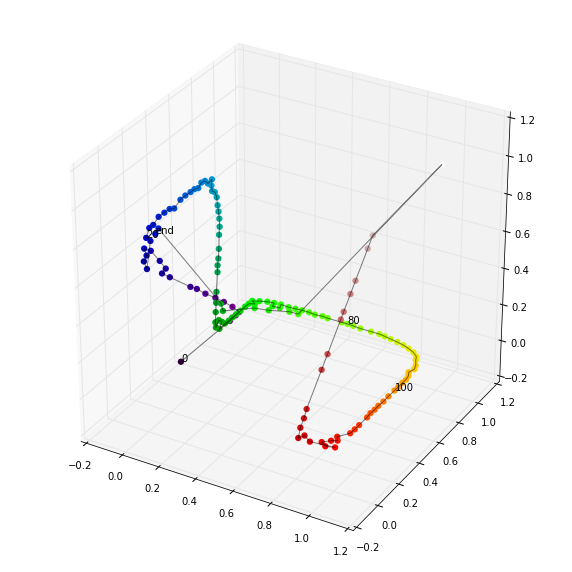

In [30]:
# Set up the figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the pixels!
ax.scatter(*u[hits].T, c=u[hits], lw=0, s=40, alpha=1)
ax.plot(*u[hits].T, 'k', alpha=0.5)
ax.text(*u[hits][0], '0')
ax.text(*u[hits][20], '20')
ax.text(*u[hits][80], '80')
ax.text(*u[hits][100], '100')
ax.text(*u[hits][-1], 'end')
plt.show()

The alogithm is missing something: it's possible to find the closest points, making a locus, but leaving out a nearby point...

In [31]:
u[hits]

array([[  1.88235294e-01,   0.00000000e+00,   2.15686275e-01],
       [  4.54901961e-01,   0.00000000e+00,   5.13725490e-01],
       [  4.86274510e-01,   0.00000000e+00,   5.52941176e-01],
       [  5.05882353e-01,   0.00000000e+00,   5.76470588e-01],
       [  4.69934641e-01,   0.00000000e+00,   5.92810458e-01],
       [  4.24836601e-01,   0.00000000e+00,   6.05228758e-01],
       [  3.80392157e-01,   0.00000000e+00,   6.13725490e-01],
       [  3.27450980e-01,   0.00000000e+00,   6.19607843e-01],
       [  2.82352941e-01,   0.00000000e+00,   6.31372549e-01],
       [  2.48039216e-01,   0.00000000e+00,   6.32352941e-01],
       [  1.38562092e-01,   0.00000000e+00,   6.50980392e-01],
       [  9.67320261e-02,   0.00000000e+00,   6.58823529e-01],
       [  1.17647059e-01,   0.00000000e+00,   6.90196078e-01],
       [  8.62745098e-02,   0.00000000e+00,   7.21568627e-01],
       [  3.92156863e-02,   0.00000000e+00,   7.60784314e-01],
       [  3.92156863e-03,   0.00000000e+00,   7.6274509

Awesome!

<hr />

## Get all pixels using nearest neighbour

`cKDTree`, hopefully fast...

In [32]:
from scipy.spatial import cKDTree

In [33]:
kdtree = cKDTree(u[hits])

We get distances and indices simultaneously:

In [34]:
#im = im.reshape(h*w, d)
dx, ix = kdtree.query(im_)

In [35]:
dx.shape, ix.shape

((64262,), (64262,))

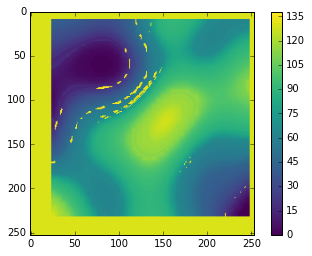

In [36]:
plt.imshow(ix.reshape((h, w)), cmap='viridis')
plt.colorbar()
plt.show()

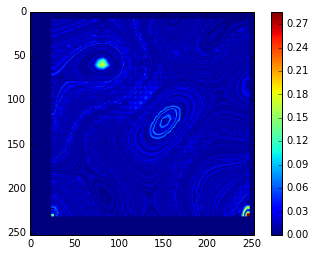

In [37]:
plt.imshow(dx.reshape((h, w)))
plt.colorbar()
plt.show()

We can apply a cutoff where the distance was unacceptably far.

In [38]:
ix = ix.astype(float)
ix[np.where(dx>0.2)] = np.nan

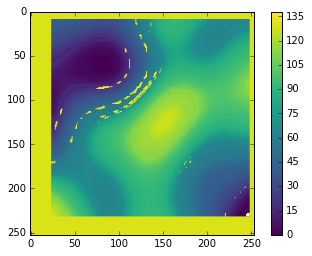

In [39]:
plt.imshow(ix.reshape((h, w)), cmap='viridis')
plt.colorbar()
plt.show()

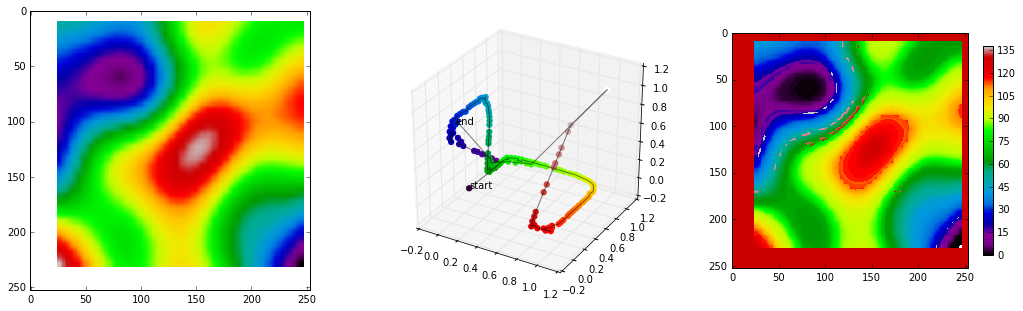

In [40]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im, interpolation='none')

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(*u[hits].T, c=u[hits], lw=0, s=40, alpha=1)
ax1.plot(*u[hits].T, 'k', alpha=0.5)
ax1.text(*u[hits][0], 'start')
ax1.text(*u[hits][-1], 'end')

ax2 = fig.add_subplot(133)
plt.imshow(ix.reshape((h, w)), cmap="spectral", interpolation='none')
plt.colorbar(shrink=0.75)

plt.show()

## TSP

Two main algos:

* LKH http://www.akira.ruc.dk/~keld/research/LKH/
* Concorde http://www.math.uwaterloo.ca/tsp/concorde.html
* OR Tools from Google https://developers.google.com/optimization/routing/tsp

* I followed these instructions for installing concorde on my Mac: http://davidsjohnson.net/TSPcourse/mac-install-concorde.txt

I think I've installed Concorde, LKH and OR Tools.

LKH and Concorde can be used via this Python package: https://github.com/perrygeo/pytsp (but note that it used to be called `pyconcorde` so you need to change the names of some functions — look at the source. I can't get the `concorde` implementation to work... see error below. 

Compile the libs and add to PATH as mentioned in the docs for `pytsp`. 

In [41]:
from pytsp import atsp_tsp, run, dumps_matrix

Add black and white to `p`:

In [142]:
p = np.vstack([[[0,0,0]], p])

In [164]:
p

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   6.20915033e-01,   1.59477124e-01],
       [  9.96862745e-01,   7.12156863e-01,   0.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   2.27450980e-01,   8.58823529e-01],
       [  9.27058824e-01,   3.92156863e-03,   0.00000000e+00],
       [  7.00280112e-02,   9.85434174e-01,   0.00000000e+00],
       [  0.00000000e+00,   6.09803922e-01,   8.17647059e-01],
       [  2.48039216e-01,   0.00000000e+00,   6.32352941e-01],
       [  7.43529412e-01,   9.77254902e-01,   0.00000000e+00],
       [  0.00000000e+00,   6.64313725e-01,   6.21176471e-01],
       [  9.29411765e-01,   9.16078431e-01,   0.00000000e+00],
       [  9.98692810e-01,   3.84313725e-01,   0.00000000e+00],
       [  0.00000000e+00,   7.35947712e-01,   0.00000000e+00],
       [  5.05882353e-01,   0.00000000e+00,   5.76470588e-01],
       [  8.00000000e-01,   5.49019608e-01,   5.4901960

In [154]:
# Make dists again and cast as integers
dists = squareform(pdist(p))
# dists = dists * 10000
# d = dists.astype(int)

# If distances are asymmetric
# matrix_sym = atsp_tsp(d, strategy="avg")

# Mine aren't
matrix_sym = d

In [155]:
outf = "/tmp/myroute_concorde.tsp"
with open(outf, 'w') as dest:
    dest.write(dumps_matrix(matrix_sym, name="My Route"))

In [156]:
tour_concorde = run(outf, start=0, solver="Concorde")

In [157]:
outf = "/tmp/myroute_lkh.tsp"
with open(outf, 'w') as dest:
    dest.write(dumps_matrix(matrix_sym, name="My Route"))

In [158]:
tour_lkh = run(outf, start=0, solver="LKH")

In [159]:
result = np.array(tour_concorde['tour'])
#result = np.array(tour_lkh['tour'])

In [166]:
result

array([  0,  28,  78, 205, 143, 202,  14, 210,  56, 116, 197,  40, 193,
       108, 233,  49, 157,   8, 220,  34,  81, 153,  98, 182, 124,  70,
       188, 196,  17, 250, 151, 227,  88, 191, 165,  57, 230, 113, 187,
       217, 106,  25, 160,  80, 173, 128,  62, 208,  97, 226,   4, 189,
        72, 212, 251,  67, 154,  37, 222,  82, 127, 252, 255,  23, 164,
       235, 177,  52, 195, 118, 215, 115, 166,   7, 236, 129, 174,  53,
       134, 232,  26, 142, 198,  92,  10, 194, 133, 111,  71,  38, 104,
       183,  21, 122, 200,  51, 119,  89,   1,  85,  93, 184,  73, 201,
       159,  55, 140, 225, 109,  33, 135,  74, 179,  13, 245,  65, 156,
        58, 243,  42, 147, 121,  19, 219, 137,  60, 185,  41, 242,  79,
       138,   6, 161, 175, 144, 145, 239,  69, 211, 103, 192,  44, 167,
       240,  86, 213, 155, 238,  20, 105, 146, 224,  75, 248,  29, 123,
        54, 178, 102,  45,  90, 168, 221,  16, 223, 125,  91,  35, 229,
       117, 203, 100,   9, 244, 150,  48, 158,  30, 169,  66, 14

Now `result` is the indices of points for the shortest path, shape `(256,)`. And `p` is our quantized colormap, shape `(256, 3)`. So we can select the points easily for an ordered colourmap.

The offset is to account for the fact that we added a black point at the start.

In [169]:
c = p[result[1:]]

Ideally I'd like all the distances too, but it wouldn't be too hard to compute these.

Now let's look at it all.

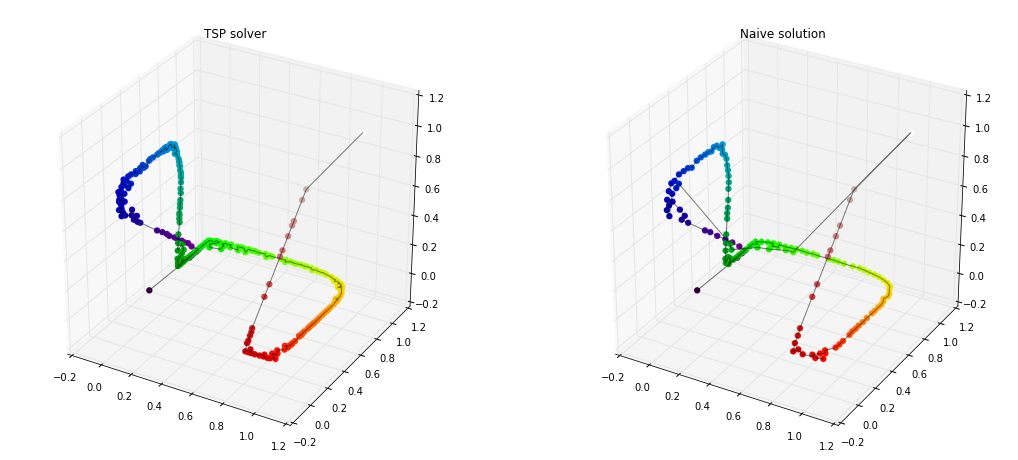

In [168]:
# Set up the figure
fig = plt.figure(figsize=(18, 8))

# Result of TSP solver
ax = fig.add_subplot(121, projection='3d')
ax.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax.plot(*c.T, 'k', alpha=0.5)
ax.set_title('TSP solver')

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(*u[hits].T, c=u[hits], lw=0, s=40, alpha=1)
ax1.plot(*u[hits].T, 'k', alpha=0.5)
ax1.set_title('Naive solution')

plt.show()

In [170]:
kdtree = cKDTree(c)

In [171]:
dx, ix = kdtree.query(im_)

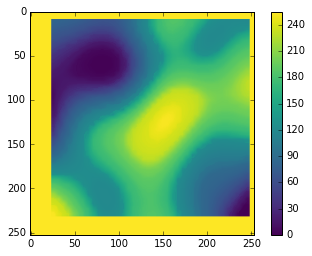

In [172]:
plt.imshow(ix.reshape((h, w)), cmap='viridis')
plt.colorbar()
plt.show()

## Naive TSP

In [44]:
import doctest
from itertools import permutations


def distance(point1, point2):
    """
    Returns the Euclidean distance of two points in the Cartesian Plane.

    >>> distance([[3,4]],[[0,0]])
    5.0
    >>> distance([[3,6]],[[10,6]])
    7.0
    """
    return cdist(point1, point2)


def total_distance(points):
    """
    Returns the length of the path passing throught
    all the points in the given order.

    >>> total_distance([[[1,2]],[[4,6]]])
    5.0
    >>> total_distance([[[3,6]],[[7,6]],[[12,6]]])
    9.0
    """
    return sum([distance(point, points[index + 1]) for index, point in enumerate(points[:-1])])


def travelling_salesman(points, start=None):
    """
    Finds the shortest route to visit all the cities by bruteforce.
    Time complexity is O(N!), so never use on long lists.

    >>> travelling_salesman([[0,0],[10,0],[6,0]])
    ([0, 0], [6, 0], [10, 0])
    >>> travelling_salesman([[0,0],[6,0],[2,3],[3,7],[0.5,9],[3,5],[9,1]])
    ([0, 0], [6, 0], [9, 1], [2, 3], [3, 5], [3, 7], [0.5, 9])
    """
    if start is None:
        start = points[0]
    return min([perm for perm in permutations(points) if perm[0] == start], key=total_distance)


def optimized_travelling_salesman(points, start=None):
    """
    As solving the problem in the brute force way is too slow,
    this function implements a simple heuristic: always
    go to the nearest city.

    Even if this algoritmh is extremely simple, it works pretty well
    giving a solution only about 25% longer than the optimal one (cit. Wikipedia),
    and runs very fast in O(N^2) time complexity.

    >>> optimized_travelling_salesman([[i,j] for i in range(5) for j in range(5)])
    [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 4], [1, 3], [1, 2], [1, 1], [1, 0], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 4], [3, 3], [3, 2], [3, 1], [3, 0], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4]]
    >>> optimized_travelling_salesman([[0,0],[10,0],[6,0]])
    [[0, 0], [6, 0], [10, 0]]
    """
    if start is None:
        start = points[0]
    must_visit = points
    path = [start]
    must_visit.remove(start)
    while must_visit:
        nearest = min(must_visit, key=lambda x: distance(path[-1], x))
        path.append(nearest)
        must_visit.remove(nearest)
    return path


def main():
    #doctest.testmod()
    points = [[[0, 0, 0]], [[1, 5.7, 0]], [[2, 3, 1]], [[3, 7, 1 ]],
              [[0.5, 9, 2]], [[3, 5, 2]], [[9, 1, 3]], [[10, 5, 3]]]
    print("""The minimum distance to visit all the following points: {}
starting at {} is {}.

The optimized algoritmh yields a path long {}.""".format(
        tuple(points),
        points[0],
        total_distance(travelling_salesman(points)),
        total_distance(optimized_travelling_salesman(points))))

main()

The minimum distance to visit all the following points: ([[0, 0, 0]], [[1, 5.7, 0]], [[2, 3, 1]], [[3, 7, 1]], [[0.5, 9, 2]], [[3, 5, 2]], [[9, 1, 3]], [[10, 5, 3]])
starting at [[0, 0, 0]] is [[ 27.46496619]].

The optimized algoritmh yields a path long [[ 29.38399704]].
